# Laboratory #4: Adversarial Learning and OOD Detection

In this laboratory session we will develop a methodology for detecting OOD samples and measuring the quality of OOD detection. We will also experiment with incorporating adversarial examples during training to render models more robust to adversarial attacks.

---
## Exercise 1: OOD Detection and Performance Evaluation
In this first exercise you will build a simple OOD detection pipeline and implement some performance metrics to evaluate its performance.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.datasets import CIFAR10, CIFAR100
import torchvision.transforms as transforms
from torch.utils.data import Subset

from models.cnn import CNN, BaseCNN
from fgsm import fgsm, get_adversarial_examples

# Select gpu if available.
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
N_EXAMPLES = 5  # Number of examples to visualize.
BATCH_SIZE = 32  # Mini-batch size for dataloader.

NORM_MEAN = np.array([0.5, 0.5, 0.5])
NORM_STD = np.array([0.5, 0.5, 0.5])


# functions to show an image
def imshow(img, normalized=True):
    npimg = img.cpu().permute(1, 2, 0).numpy()
    if normalized:
        npimg = (npimg * NORM_STD[None,None]) + NORM_MEAN[None,None]
    npimg = np.clip(npimg, a_min=0.0, a_max=1.0)
    plt.imshow(npimg)

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.cpu().numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        imshow(images[idx].cpu())
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            ID_CLASSES[preds[idx]],
            probs[idx] * 100.0,
            ID_CLASSES[labels[idx]]),
            color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

### Exercise 1.1: Build a simple OOD detection pipeline

Implement an OOD detection pipeline (like in the Flipped Activity notebook) using an ID and an OOD dataset of your choice. Some options:

+ CIFAR-10 (ID), Subset of CIFAR-100 (OOD). You will need to wrap CIFAR-100 in some way to select a subset of classes that are *not* in CIFAR-10 (see `torch.utils.data.Subset`).
+ Labeled Faces in the Wild (ID), CIFAR-10 or FakeData (OOD). The LfW dataset is available in Scikit-learn (see `sklearn.datasets.fetch_lfw_people`).
+ Something else, but if using images keep the images reasonably small!

In this exercise your *OOD Detector* should produce a score representing how "out of distribution" a test sample is. We will implement some metrics in the next exercise, but for now use the techniques from the flipped activity notebook to judge how well OOD scoring is working (i.e. histograms).

**Note**: Make sure you make a validation split of your ID dataset for testing.

In [2]:
# We will use CIFAR-10 as our in-distribution dataset.
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load the datasets and setup the DataLoaders.
cifar_train = CIFAR10(root='./data', train=True, download=True, transform=transform)
# Split train into train and validation.
val_size = int(0.1 * len(cifar_train))
I = np.random.permutation(len(cifar_train))
ds_train = Subset(cifar_train, I[val_size:])
ds_val = Subset(cifar_train, I[:val_size])

ds_test = CIFAR10(root='./data', train=False, download=True, transform=transform)

dl_train = torch.utils.data.DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
dl_val = torch.utils.data.DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# In case we want to pretty-print classifications.
ID_CLASSES = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


torch.Size([32, 3, 32, 32]) torch.Size([32])
 deer  deer truck   dog   car


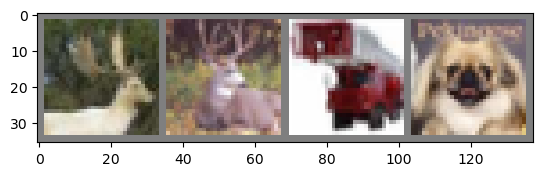

In [3]:
images,labels = next(iter(dl_train))
print(images.shape, labels.shape)
# show images
imshow(torchvision.utils.make_grid(images[0:4]))
print(' '.join('%5s' % ID_CLASSES[labels[j]] for j in range(N_EXAMPLES)))

#### CIFAR-100 Subset
For the OOD dataset, we select a subset of CIFAR-100 dataset. Even if CIFAR-100 classes are disjoint from CIFAR-10, some classes may be similar or equivalent to their CIFAR-10 counterpart (e.g "streetcar" and "car", "truck" and "pickup truck", "dog" or "cat" and "fox" ...). 

Therefore, we selected only classes describing "humans" classes from CIFAR-100, which are not present in CIFAR-10. This should make the OOD detection easier (and more meaningful) than using the full dataset.

In [4]:
# Fake dataset.
ds_fake = CIFAR100(root='./data', train=True, download=True, transform=transform)

# Subset of CIFAR-100 describing humans
OOD_CLASSES = ['baby','boy','girl','man','woman']
OOD_CLASSES_IDX = {c:ds_fake.class_to_idx[c] for c in OOD_CLASSES}
OOD_IDX_CLASSES = {v:k for k,v in OOD_CLASSES_IDX.items()}
indices_to_select = [i for i in range(len(ds_fake)) if ds_fake.targets[i] in OOD_CLASSES_IDX.values()]

ds_fake = Subset(ds_fake,indices_to_select)
dl_fake = torch.utils.data.DataLoader(ds_fake, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Files already downloaded and verified


torch.Size([32, 3, 32, 32]) torch.Size([32])
  boy   boy   boy woman


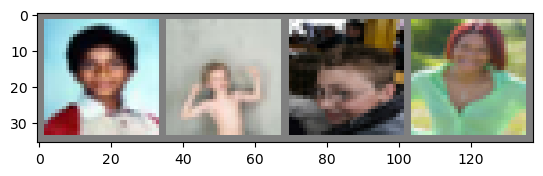

In [5]:
images,labels = next(iter(dl_fake))
print(images.shape, labels.shape)
# show images
imshow(torchvision.utils.make_grid(images[0:4]))
print(' '.join('%5s' % OOD_IDX_CLASSES[labels[j].item()] for j in range(4)))

## Model

We will use the CNN model from the flipped activity notebook

In [6]:
# USE THIS CELL TO LOAD THE PRETRAINED MODEL.
model = BaseCNN().to(DEVICE)
model.load_state_dict(torch.load('./artifacts/cifar10_CNN.pth'))

model.eval()

BaseCNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [7]:
from tqdm import tqdm

# Function to collect all logits from the model on entire dataset.
def collect_logits(model, dl):
    logits = []
    with torch.no_grad():
        for (Xs, _) in tqdm(dl):
            logits.append(model(Xs.to(DEVICE)).cpu().numpy())
    return np.vstack(logits)

In [8]:
# Collect logits on CIFAR-10 test set (ID) and noise (very OOD).
logits_ID = collect_logits(model, dl_test)
logits_OOD = collect_logits(model, dl_fake)

100%|██████████| 79/79 [00:06<00:00, 12.03it/s]


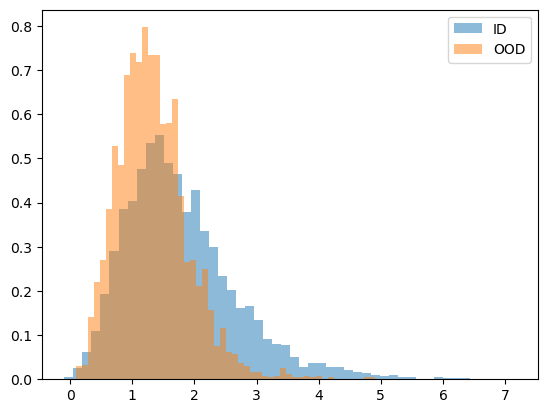

In [9]:
# Plot the *distribution* of max logit outputs.
_ = plt.hist(logits_ID.max(1), 50, density=True, alpha=0.5, label='ID')
_ = plt.hist(logits_OOD.max(1), 50, density=True, alpha=0.5, label='OOD')
plt.legend()

Instead of just using the maximum logit output, we can rescale the distribution with a temperature-scaled softmax. This is done by using a temperature parameter $T$ to "soften" the logits before applying the softmax function. The softmax function is defined as:

$$P(y=y_i) = \frac{e^\frac{y_i}{T}}{\sum_{k=1}^n e^\frac{y_k}{T}}$$

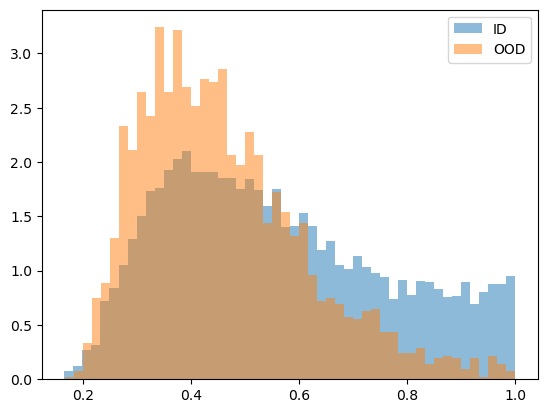

In [10]:
t = 0.7

probs_ID = F.softmax(torch.tensor(logits_ID/t), dim=1).numpy()
probs_OOD = F.softmax(torch.tensor(logits_OOD/t), dim=1).numpy()

# Plot the *distribution* of max logit outputs.
_ = plt.hist(probs_ID.max(1), 50, density=True, alpha=0.5, label='ID')
_ = plt.hist(probs_OOD.max(1), 50, density=True, alpha=0.5, label='OOD')
plt.legend()

### Exercise 1.2: Measure your OOD detection performance

There are several metrics used to evaluate OOD detection performance, we will concentrate on two threshold-free approaches: the area under the Receiver Operator Characteristic (ROC) curve for ID classification, and the area under the Precision-Recall curve for *both* ID and OOD scoring. See [the ODIN paper](https://arxiv.org/pdf/1706.02690.pdf) section 4.3 for a description of OOD metrics.

Use the functions in `sklearn.metrics` to produce ROC and PR curves for your OOD detector. Some useful functions:

+ [`sklearn.metric.RocCurveDisplay.from_predictions`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html)
+ [`sklearn.metrics.PrecisionRecallDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html)

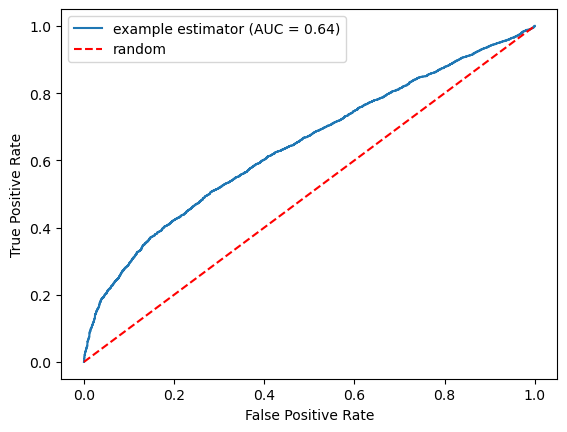

In [11]:
from sklearn.metrics import RocCurveDisplay, roc_curve,auc, PrecisionRecallDisplay

labels = np.hstack([np.ones_like(probs_ID.max(1)), np.zeros_like(probs_OOD.max(1))])



probs = np.hstack([probs_ID.max(1), probs_OOD.max(1)])

fpr, tpr, thresholds = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)

display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='example estimator')
display.plot()
# add random line
plt.plot([0, 1], [0, 1], color='red', linestyle='--',label='random')
plt.legend()
plt.show()

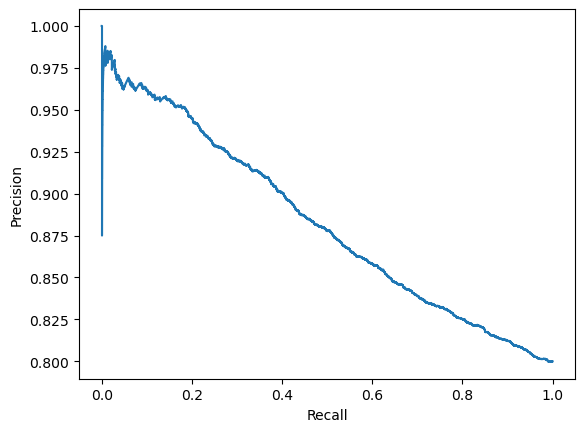

In [12]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(labels, probs)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

plt.show()

---
## Exercise 2: Enhancing Robustness to Adversarial Attack

In this second exercise we will experiment with enhancing our base model to be (more) robust to adversarial attacks. 

### Exercise 2.1: Implement FGSM and generate adversarial examples

Recall that the Fast Gradient Sign Method (FGSM) perturbs samples in the direction of the gradient with respect to the input $\mathbf{x}$:
$$ \boldsymbol{\eta}(\mathbf{x}) = \varepsilon \mathrm{sign}(\nabla_{\mathbf{x}} \mathcal{L}(\boldsymbol{\theta}, \mathbf{x}, y)) ) $$
Implement FGSM and generate some *adversarial examples* using your trained ID model. Evaluate these samples qualitatively and quantitatively. Evaluate how dependent on $\varepsilon$ the quality of these samples are. 

In [13]:
def test_adversarial( model, device, test_loader, epsilon ):
    # Accuracy counter
    correct = 0
    adv_examples = None

    # Loop over all examples in test set
    for i,(Xs, ys) in enumerate(test_loader):
        Xs, ys = Xs.to(device), ys.to(device)
        Xs_adversarial_normalized =  get_adversarial_examples(model, Xs, ys, epsilon)
        final_out = model(Xs_adversarial_normalized)
        final_pred = final_out.argmax(1) # get the index of the max log-probability
        correct += (final_pred.squeeze() == ys).sum().item()
        # add first batch of adversarial examples
        if i==0:
            adv_ex = Xs_adversarial_normalized.detach().cpu().numpy()
            adv_examples = (adv_ex, ys, final_pred)

    # Calculate final accuracy for this epsilon
    acc = correct/float(len(test_loader) * BATCH_SIZE)
    print(f"Epsilon: {epsilon:.2f}\tTest Accuracy = {correct} / {len(test_loader) * BATCH_SIZE} = {acc}")

    # Return the accuracy and an adversarial example
    return acc, adv_examples

We will use the pretrained model, provided along with the notebook during the flipped lesson. The pretrained model reaches 62% accuracy on the CIFAR-10 test set.
Here are a few prediction examples:  

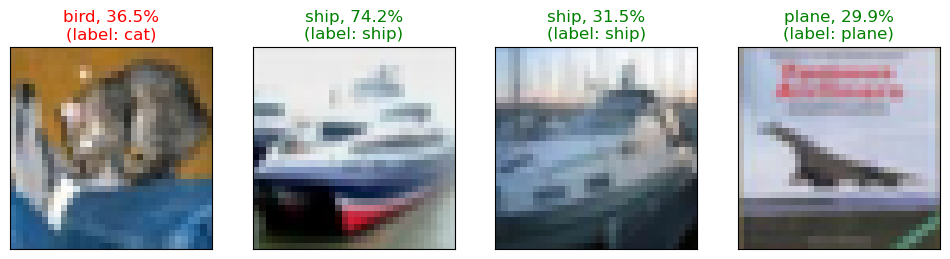

In [14]:
images,labels = next(iter(dl_test))
fig = plot_classes_preds(model.to(DEVICE), images.to(DEVICE), labels)

We will now execute the FGSM attack on a single sample, and show the original and perturbed images side-by-side, along with the perturbation itself.

init pred: ship
final pred: car


Text(0.5, 1.0, 'gradient sign')

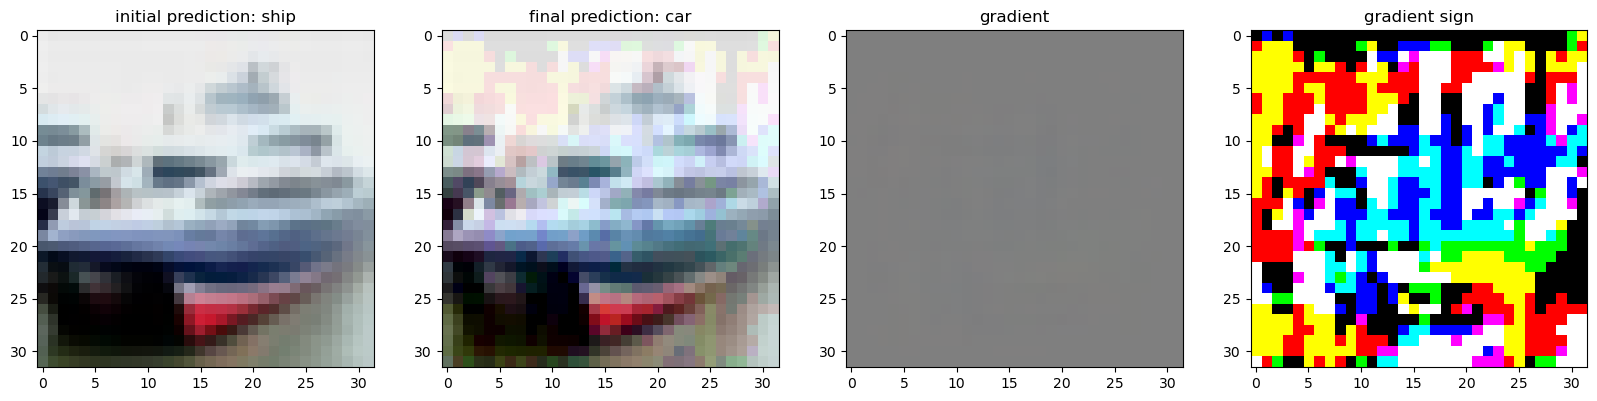

In [15]:
images, labels = next(iter(dl_test))
x, y = images[1], labels[1]

x = x.unsqueeze(0).to(DEVICE)
x.requires_grad = True
logits = model(x)
init_pred = torch.argmax(logits, dim=1)
print(f"init pred: {ID_CLASSES[init_pred]}")
# If the initial prediction is wrong, attack and gradient could be wrong?
loss = F.cross_entropy(logits, y.unsqueeze(0).to(DEVICE))
model.zero_grad()
loss.backward()
image_grad = x.grad.data
# mask = torch.nonzero((init_pred != ys).int())
# image_grad[mask] = torch.zeros(image_grad[mask].shape[1:])
# print(image_grad.shape)
x_perturbed, grad_sign = fgsm(x, image_grad, 0.1)
# Xs_adv = transforms.Normalize(NORM_MEAN, NORM_STD)(Xs_adv)
# Re-classify the perturbed image
output = model(x_perturbed)

# Check for success
final_pred = torch.argmax(output, dim=1).detach() # get the index of the max log-probability
print(f"final pred: {ID_CLASSES[final_pred]}")

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 4, 1)
imshow(x.detach().squeeze())
ax.set_title(f"initial prediction: {ID_CLASSES[init_pred]}")
ax = fig.add_subplot(1, 4, 2)
imshow(x_perturbed.detach().squeeze())
ax.set_title(f"final prediction: {ID_CLASSES[final_pred]}")
ax = fig.add_subplot(1, 4, 3)
imshow(image_grad.detach().squeeze())
ax.set_title("gradient")
ax = fig.add_subplot(1, 4, 4)
imshow(grad_sign.detach().squeeze())
ax.set_title("gradient sign")

The attack was successful. We can see that the image is now misclassified as "car". The perturbation of the image is clearly visible. 

Let's visualize a few more perturbed samples. As we can see, all images are now misclassified.

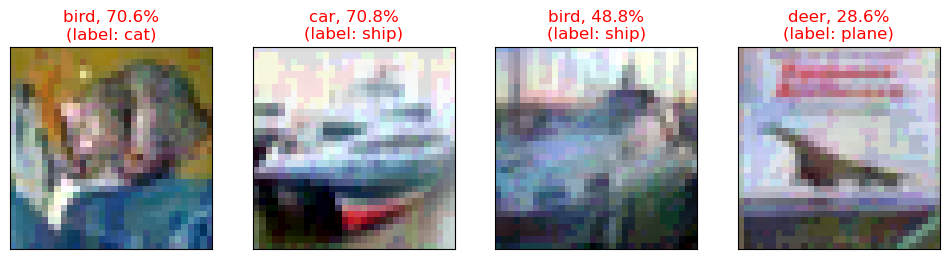

In [16]:
images,labels = next(iter(dl_test))
adv = get_adversarial_examples(model.cpu(), images, labels, eps=0.1)

logits = model(adv)
preds = logits.max(1, keepdim=True)[1]

fig = plot_classes_preds(model.cpu(), adv, labels)

In [17]:
N_EXAMPLES = 5
model = model.to(DEVICE)

accuracies = []
examples = []

epsilons = np.arange(0, 0.3, 0.05)

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test_adversarial(model, DEVICE, dl_test, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0.00	Test Accuracy = 4632 / 10016 = 0.46246006389776356
Epsilon: 0.05	Test Accuracy = 893 / 10016 = 0.0891573482428115
Epsilon: 0.10	Test Accuracy = 167 / 10016 = 0.016673322683706072
Epsilon: 0.15	Test Accuracy = 56 / 10016 = 0.005591054313099041
Epsilon: 0.20	Test Accuracy = 31 / 10016 = 0.0030950479233226836
Epsilon: 0.25	Test Accuracy = 23 / 10016 = 0.002296325878594249


As we can see from the plot, the accuracy drops from 60% to less than 10% (which is equivalent to random choice on CIFAR-10) even with the smaller perturbation, thus the adversarial attacks are very effective on our model.

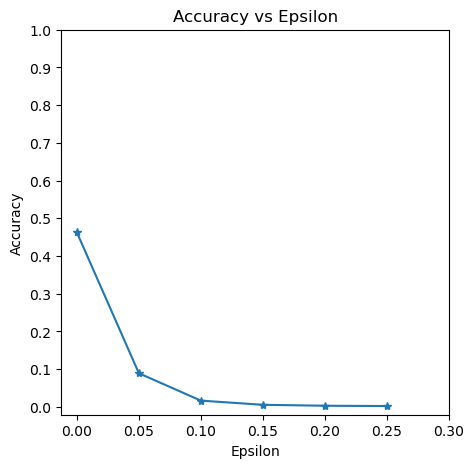

In [18]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-", label="standard model")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

We know that the FGSM attack is very effective, but the image quality degrades quickly when using a higher $\epsilon$. At $\varepsilon= 0.1$ the perturbation is clearly visible, and at $\varepsilon=0.25$ the image is almost unrecognizable. 

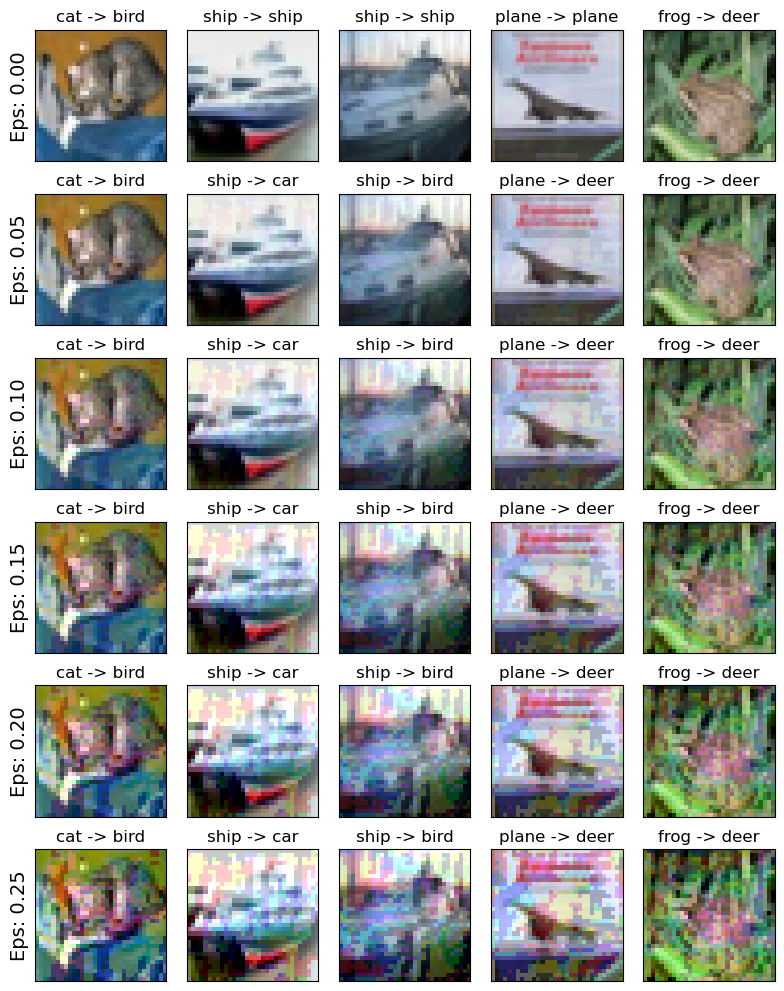

In [19]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    ex, orig, adv = examples[i]
    for j in range(0,N_EXAMPLES):
        cnt += 1
        plt.subplot(len(epsilons),N_EXAMPLES,cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]:.2f}", fontsize=14)
        plt.title(f"{ID_CLASSES[orig[j]]} -> {ID_CLASSES[adv[j]]}")
        imshow(torch.from_numpy(ex[j]),normalized=True)
plt.tight_layout()
plt.show()

### Exercise 2.2: Augment training with adversarial examples

Use your implementation of FGSM to augment your training dataset with adversarial samples. Ideally, you should implement this data augmentation *on the fly* so that the adversarial samples are always generated using the current model. Evaluate whether the model is more (or less) robust to ID samples using your OOD detection pipeline and metrics you implemented in Exercise 1.

In [20]:
def train_epoch(model, optimizer, device, train_loader, val_loader, epsilon ):
    # Accuracy counter
    correct = 0
    adv_examples = []
    losses = []
    # Loop over all examples in test set
    for Xs, ys in train_loader:
        Xs, ys = Xs.to(device), ys.to(device)
        Xs_adversarial_normalized = get_adversarial_examples(model, Xs, ys, epsilon)
        logits = model(Xs_adversarial_normalized)
        loss = F.cross_entropy(logits, ys)
        losses.append(loss.item())
        # Gradients are already zeroed out by attack function.
        loss.backward()
        optimizer.step()
        preds = torch.argmax(logits, dim=1)
        correct += (preds.squeeze() == ys).sum().item()

    train_acc = correct/float(len(train_loader) * BATCH_SIZE)
    # Calculate validation accuracy for this epsilon
    valid_acc, _ = test_adversarial(model, device, val_loader, epsilon)

    # Return the accuracy and an adversarial example
    return train_acc, valid_acc, losses

In [21]:
from torch import optim
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(0,10):
    train_acc, valid_acc, losses = train_epoch(model, optimizer, DEVICE, dl_train, dl_test, epsilon=0.1)
    print(f"Epoch {epoch}:\tTrain Accuracy = {train_acc:.2f}\tValid Accuracy = {valid_acc:.2f}\tLoss = {np.mean(losses):.2f}")

Epsilon: 0.10	Test Accuracy = 1664 / 10016 = 0.16613418530351437
Epoch 0:	Train Accuracy = 0.14	Valid Accuracy = 0.17	Loss = 2.29
Epsilon: 0.10	Test Accuracy = 1795 / 10016 = 0.1792132587859425
Epoch 1:	Train Accuracy = 0.18	Valid Accuracy = 0.18	Loss = 2.19
Epsilon: 0.10	Test Accuracy = 1697 / 10016 = 0.16942891373801916
Epoch 2:	Train Accuracy = 0.19	Valid Accuracy = 0.17	Loss = 2.15
Epsilon: 0.10	Test Accuracy = 1953 / 10016 = 0.19498801916932906
Epoch 3:	Train Accuracy = 0.20	Valid Accuracy = 0.19	Loss = 2.14
Epsilon: 0.10	Test Accuracy = 1979 / 10016 = 0.19758386581469647
Epoch 4:	Train Accuracy = 0.20	Valid Accuracy = 0.20	Loss = 2.12
Epsilon: 0.10	Test Accuracy = 1978 / 10016 = 0.19748402555910544
Epoch 5:	Train Accuracy = 0.21	Valid Accuracy = 0.20	Loss = 2.11
Epsilon: 0.10	Test Accuracy = 2135 / 10016 = 0.21315894568690097
Epoch 6:	Train Accuracy = 0.21	Valid Accuracy = 0.21	Loss = 2.10
Epsilon: 0.10	Test Accuracy = 2049 / 10016 = 0.2045726837060703
Epoch 7:	Train Accuracy = 0

Epsilon: 0.00	Test Accuracy = 5338 / 10016 = 0.5329472843450479
Epsilon: 0.05	Test Accuracy = 3316 / 10016 = 0.3310702875399361
Epsilon: 0.10	Test Accuracy = 2149 / 10016 = 0.21455670926517573
Epsilon: 0.15	Test Accuracy = 1493 / 10016 = 0.14906150159744408
Epsilon: 0.20	Test Accuracy = 1107 / 10016 = 0.11052316293929712
Epsilon: 0.25	Test Accuracy = 836 / 10016 = 0.08346645367412141


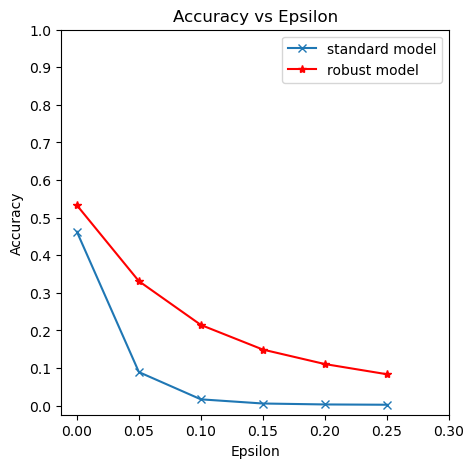

In [22]:
robust_accuracies = []
robust_examples = []

epsilons = np.arange(0, 0.3, 0.05)

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test_adversarial(model, DEVICE, dl_test, eps)
    robust_accuracies.append(acc)
    robust_examples.append(ex)

plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "x-", label="standard model")
plt.plot(epsilons, robust_accuracies, "*-", color="red", label="robust model")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

We can see that the model is more robust to adversarial attacks, reaching an accuracy of 30% on the adversarial samples. We can also see that the accuracy is higher at $\epsilon = 0.1$, which is the value used for perturbations during training. To produce models robust to a wider range of perturbation, we would need to train the model varying the value of $\epsilon$. 

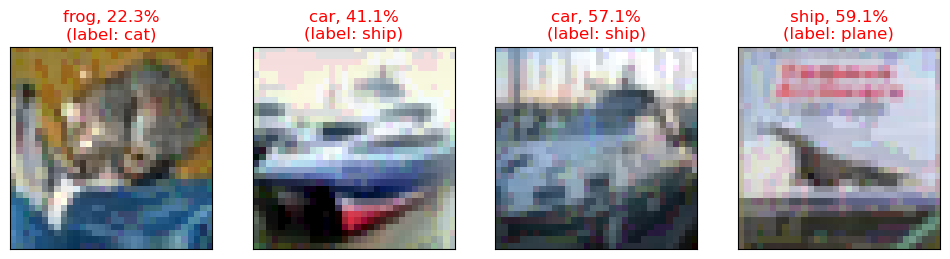

In [23]:
images,labels = next(iter(dl_test))
adv = get_adversarial_examples(model.cpu(), images, labels, eps=0.1)

logits = model(adv)
preds = logits.max(1, keepdim=True)[1]

fig = plot_classes_preds(model.cpu(), adv, labels)

For this small sample, we can see that even with a quite strong perturbation, the FGSM attack is less effective. 
Let's also see the gradient and the gradient sign for a single example.

init pred: ship
final pred: car


Text(0.5, 1.0, 'gradient sign')

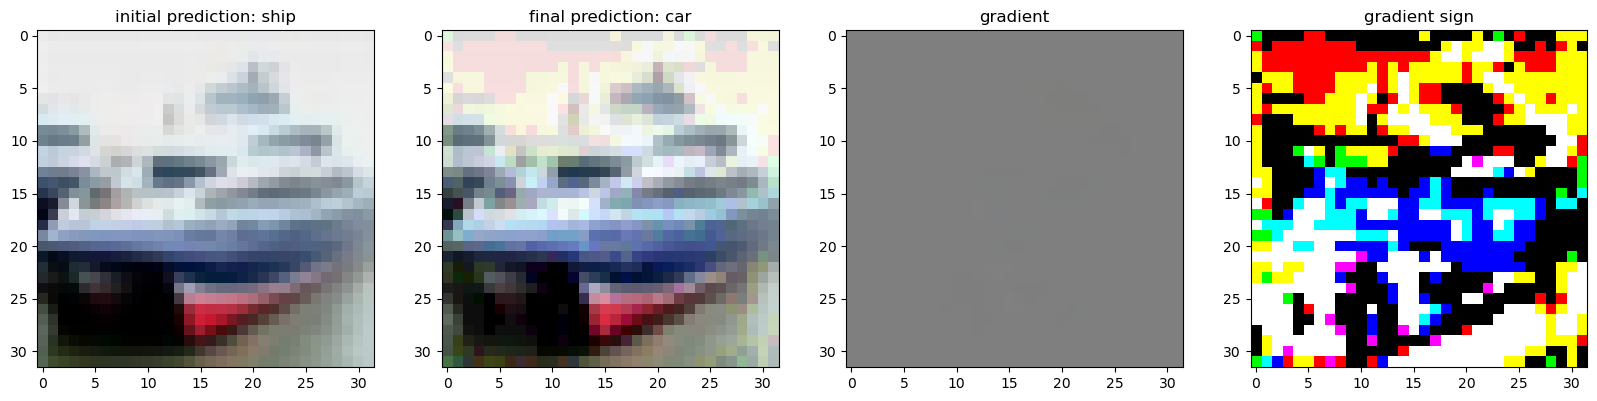

In [24]:
model.to(DEVICE)
images, labels = next(iter(dl_test))
x, y = images[1], labels[1]

x = x.unsqueeze(0).to(DEVICE)
x.requires_grad = True
logits = model(x)
init_pred = torch.argmax(logits, dim=1)
print(f"init pred: {ID_CLASSES[init_pred]}")
# If the initial prediction is wrong, attack and gradient could be wrong?
loss = F.cross_entropy(logits, y.unsqueeze(0).to(DEVICE))
model.zero_grad()
loss.backward()
image_grad = x.grad.data
# mask = torch.nonzero((init_pred != ys).int())
# image_grad[mask] = torch.zeros(image_grad[mask].shape[1:])
# print(image_grad.shape)
x_perturbed, grad_sign = fgsm(x, image_grad, 0.1)
# Xs_adv = transforms.Normalize(NORM_MEAN, NORM_STD)(Xs_adv)
# Re-classify the perturbed image
output = model(x_perturbed)

# Check for success
final_pred = torch.argmax(output, dim=1).detach() # get the index of the max log-probability
print(f"final pred: {ID_CLASSES[final_pred]}")

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 4, 1)
imshow(x.detach().squeeze())
ax.set_title(f"initial prediction: {ID_CLASSES[init_pred]}")
ax = fig.add_subplot(1, 4, 2)
imshow(x_perturbed.detach().squeeze())
ax.set_title(f"final prediction: {ID_CLASSES[final_pred]}")
ax = fig.add_subplot(1, 4, 3)
imshow(image_grad.detach().squeeze())
ax.set_title("gradient")
ax = fig.add_subplot(1, 4, 4)
imshow(grad_sign.detach().squeeze())
ax.set_title("gradient sign")

The jacobian of the image of the robust model is more salient than the jacobian of the original model.

#### Out-of Distribution Detection
Now that we have a model that is robust to adversarial attack, let's see if it is also more robust to OOD samples. We will use the same OOD detection pipeline as in Exercise 1.1.

In [25]:
# Collect logits on CIFAR-10 test set (ID) and noise (very OOD).
logits_ID = collect_logits(model, dl_test)
logits_OOD = collect_logits(model, dl_fake)

100%|██████████| 79/79 [00:06<00:00, 12.60it/s]


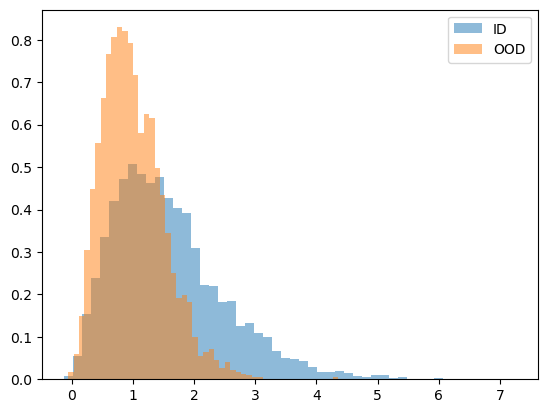

In [26]:
# Plot the *distribution* of max logit outputs.
_ = plt.hist(logits_ID.max(1), 50, density=True, alpha=0.5, label='ID')
_ = plt.hist(logits_OOD.max(1), 50, density=True, alpha=0.5, label='OOD')
plt.legend()

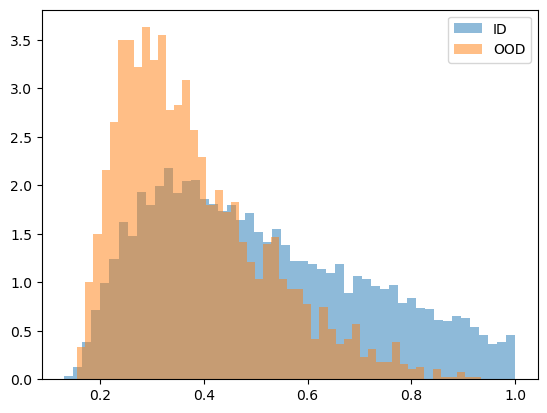

In [27]:
t = 0.7

probs_ID = F.softmax(torch.tensor(logits_ID/t), dim=1).numpy()
probs_OOD = F.softmax(torch.tensor(logits_OOD/t), dim=1).numpy()

# Plot the *distribution* of max probability outputs.

_ = plt.hist(probs_ID.max(1), 50, density=True, alpha=0.5, label='ID')
_ = plt.hist(probs_OOD.max(1), 50, density=True, alpha=0.5, label='OOD')
plt.legend()

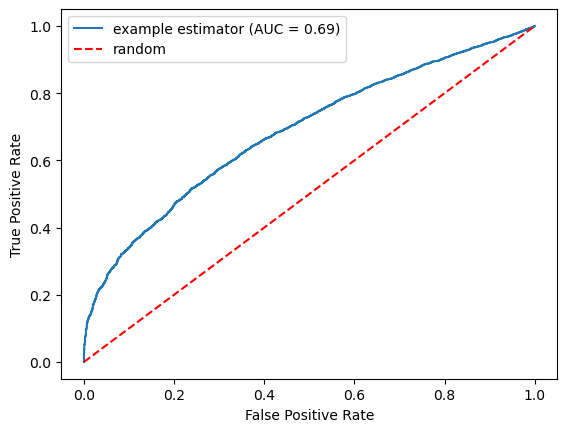

In [28]:
from sklearn.metrics import RocCurveDisplay, roc_curve,auc, PrecisionRecallDisplay

labels = np.hstack([np.ones_like(probs_ID.max(1)), np.zeros_like(probs_OOD.max(1))])



probs = np.hstack([probs_ID.max(1), probs_OOD.max(1)])

fpr, tpr, thresholds = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)

display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='example estimator')
display.plot()
# add random line
plt.plot([0, 1], [0, 1], color='red', linestyle='--',label='random')
plt.legend()
plt.show()

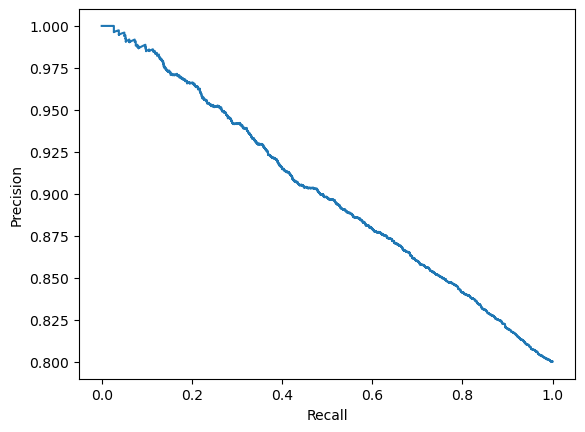

In [29]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(labels, probs)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

plt.show()

The ID samples result more salient, but still the OOD samples have high scores and are not easily distinguishable from ID samples.

---
## Exercise 3: Wildcard

You know the drill. Pick *ONE* of the following exercises to complete.

### Exercise 3.1: Implement ODIN for OOD detection
ODIN is a very simple approach, and you can already start experimenting by implementing a temperature hyperparameter in your base model and doing a grid search on $T$ and $\varepsilon$.

### Exercise 3.2: Implement JARN
In exercise 2.2 you already implemented Jacobian-regularized learning to make your model more robust to adversarial samples. Add a *discriminator* to your model to encourage the adversarial samples used for regularization to be more *salient*.

See [the JARN paper](https://arxiv.org/abs/1912.10185) for more details.

### Exercise 3.3: Experiment with *targeted* adversarial attacks
Implement the targeted Fast Gradient Sign Method to generate adversarial samples that *imitate* samples from a specific class. Evaluate your adversarial samples qualitatively and quantitatively.

### Exercise 3.2

We implemented JARN on CIFAR-10. 

![JARN training architecture](./images/JARN_architecture.png)

### Architecture

- The Discriminator network has a structure similar to the generator, with a single output and a sigmoid activation.
- The Adapter network is a single Convolutional layer with a tanh activation as in the paper


### Training

The adversarial training procedure follows the one written in the paper.

![JARN training algorithm](./images/JARN_algorithm.png)

The adversarial training procedure can lead to an instable training. In particular, we observed that the discriminator tends to become too strong, not providing any more training signal to the generator. As in GANs, we can attribute this behavior to the fact that the discrimination task is much easier than the generation task.

We will thus use some tricks typically used in GANs, shown in [Improved techniques for training GANs](https://arxiv.org/pdf/1606.03498.pdf) paper:

- Use a different learning rate for the discriminator and the generator and/or different optimizers
- Train the generator for more steps than the discriminator (We will update the discriminator every $n$ steps of the generator)
- Avoid sparse gradients by using LeakyReLU instead of ReLU
- Add noise to the labels of the discriminator

#### Failure modes
We observed the following failure modes:
- **Discriminator wins**: The discriminator becomes too strong, and the generator receives less and less training signal. To avoid this, we used a lower learning rate, changed Adam optimizer to SGD and reduced the training steps for the discriminator.
- **Mode collapse**: The output of the Adapter layer changes to a constant value for the whole image. We think that the adversarial loss could be also easy to fool with a constant output, so we came up with two solutions:
  - Add a regularization term to the adversarial loss, to penalize constant outputs, or measure the diversity
  - Avoid a learning-based approach and use a fixed Adapter layer. We chose to use a per-image normalization with Instance Normalization to make the Jacobian be in the same range as the input image.


In [30]:
import time
import torch.optim as optim
import torchmetrics

from models.cnn import CNN
from models.gan import Generator, Discriminator
from fgsm import get_adversarial_examples

# ================
# hyperparameters
nepochs = 10
lambda_ = 1.
eps = 0.1
update_d_every_n_steps = 200
add_noise = False
add_fgsm_adversarial = True
# ================

backbone = CNN(10,num_conv_layers=4,num_fc_layers=1,activation='LeakyReLU').to(DEVICE)
print(backbone)

# generator
# netG = model
netG = Generator(
    backbone = backbone,
    criterion = nn.CrossEntropyLoss()
    ).to(DEVICE)
# netG.load_state_dict(torch.load('./artifacts/cifar10_CNN.pth'))
netG.train()
# discriminator
criterion = nn.BCELoss()
netD = Discriminator(CNN(1,num_conv_layers=5,num_fc_layers=0,activation='LeakyReLU')).to(DEVICE)
netD.train()
print(netD)
# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.


# optimizers
optimizerG = optim.Adam(netG.parameters(), lr=1e-3)
optimizerD = optim.SGD(netD.parameters(), lr=1e-2, momentum=0.9)

loss_g, loss_d, acc_g, acc_d = [], [], [], []
js, j_primes = [],[]

g_cls_metric = torchmetrics.Accuracy(task="multiclass",num_classes=10).to(DEVICE)
g_adv_metric = torchmetrics.Accuracy(task="multiclass",num_classes=10).to(DEVICE)
d_metric = torchmetrics.Accuracy(task="binary").to(DEVICE)

for epoch in range(nepochs):
    cls_correct = 0
    adv_correct = 0
    netG.train()
    netD.train()
    for i, (x, labels) in enumerate(dl_train, 0):
        x = x.to(DEVICE)
        labels = labels.to(DEVICE)
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        # forward pass real batch through D
        label = torch.full((x.size(0),), real_label, dtype=torch.float, device=DEVICE)
        output = netD(x)
        # calculate loss on all-real batch
        errD_real = criterion(output, label)
        # calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        # generate fake image batch with G
        fake, (J, errG_cls, preds_cls) = netG.generate(x,labels)
        # label fake batch
        label.fill_(fake_label)
        # classify all fake batch with D
        output = netD(fake.detach())
        # calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        if i % update_d_every_n_steps == 0:
            optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        if add_fgsm_adversarial:
            x_perturbed, _ = fgsm(x, J, eps)
            # Re-classify the perturbed image
            output = netG(x_perturbed)
            # Calculate the loss
            loss = F.cross_entropy(output, labels)
            loss.backward()
            preds_adv = output.argmax(dim=1)
            adv_correct += (preds_adv == labels).sum().item()
        # label fake batch
        label.fill_(real_label)
        # since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake)
        # calculate G's loss based on this output
        errG_adv = criterion(output, label)
        # calculate gradients for G
        errG = errG_cls + lambda_ * errG_adv
        errG.backward()
        D_G_z2 = output.mean().item()
        # update G
        optimizerG.step()
        # calculate accuracy
        cls_correct += (preds_cls == labels).sum().item()
        if i % 100 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f Loss_Adv: %.4f D(x): %.4f D(G(z)): %.4f / %.4f Accuracy: %.4f Adv Accuracy: %.4f'
                  % (epoch, nepochs, i, len(dl_train),
                     errD.item(), errG.item(), errG_adv.item(), D_x, D_G_z1, D_G_z2, cls_correct/((i+1)*BATCH_SIZE), adv_correct/((i+1)*BATCH_SIZE)))
        if i % 500 == 0:
            loss_g.append(errG.item())
            loss_d.append(errD.item())
            j_primes.append(fake.detach().cpu().numpy())
    
    # validation
    netG.eval()
    netD.eval()
    cls_correct = 0
    adv_correct = 0
    for i, (x, labels) in enumerate(dl_val, 0):
        x = x.to(DEVICE)
        labels = labels.to(DEVICE)
        # forward pass real batch through G
        x.requires_grad = True
        output = netG(x)
        loss = F.cross_entropy(output, labels)
        loss.backward()
        preds_cls = output.argmax(dim=1)
        # add the gradients from the all-real and all-fake batches
        J = x.grad.detach()
        x_perturbed, _ = fgsm(x, J, eps)
        # Re-classify the perturbed image
        with torch.no_grad():
            output = netG(x_perturbed)
        preds_adv = output.argmax(dim=1)
        # Calculate the accuracy
        adv_correct += (preds_adv == labels).sum().item()
        cls_correct += (preds_cls == labels).sum().item()
    print('Validation Accuracy: %.4f Adv Accuracy: %.4f' % (cls_correct/len(dl_val.dataset), adv_correct/len(dl_val.dataset)))


    # adv_acc, _ = test_adversarial(netG, DEVICE, dl_test, 0.05)
    # print('[%d/%d] Adversarial Accuracy: %.4f' % (epoch, nepochs, adv_acc))

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, 

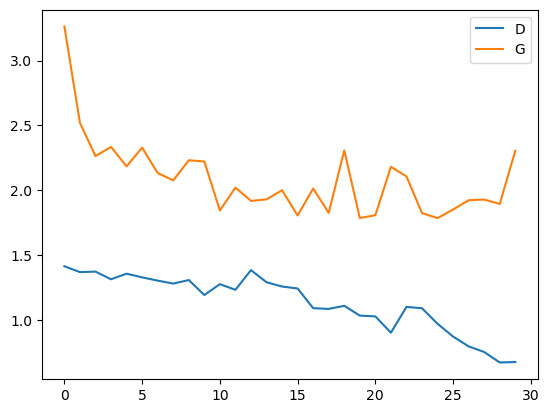

In [31]:
#Plot the loss
plt.plot(loss_d, label='D')
plt.plot(loss_g, label='G')
plt.legend()

min x: -1.0| max x: 1.0 | min J_prime: -0.9679471254348755 | max J_prime: 0.9587511420249939 | min J: -0.004227023106068373 | max J: 0.0038946238346397877


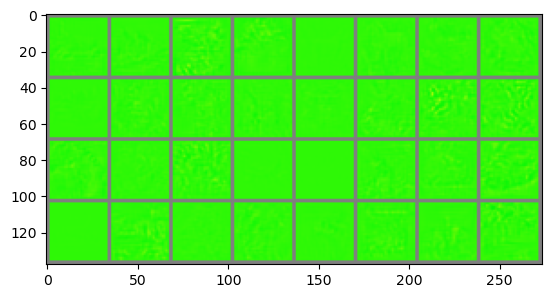

In [35]:
data, labels = next(iter(dl_train))
data, labels = data.to(DEVICE), labels.to(DEVICE)

netG.eval()

J_prime, J = netG.generate(data,labels)
J = J[0]


print(f'min x: {x.min()}| max x: {x.max()} | min J_prime: {J_prime.min()} | max J_prime: {J_prime.max()} | min J: {J.min()} | max J: {J.max()}')
imshow(torchvision.utils.make_grid(J_prime.detach().cpu()))

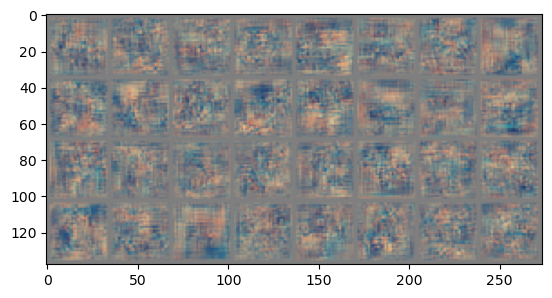

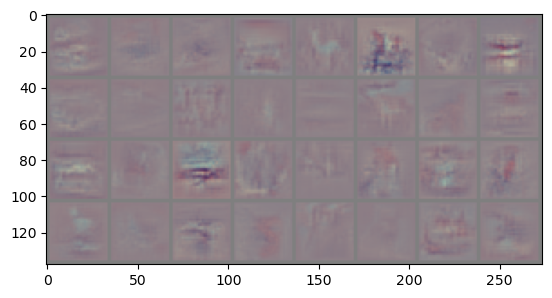

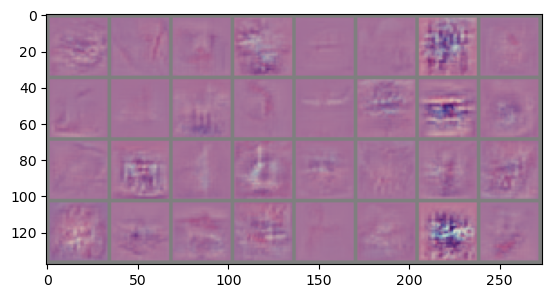

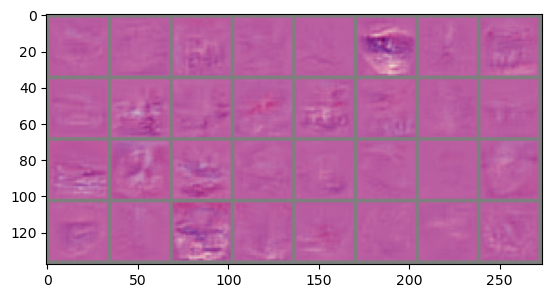

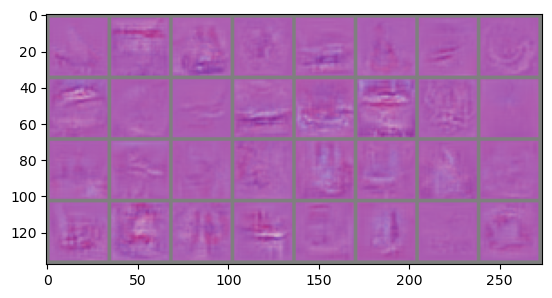

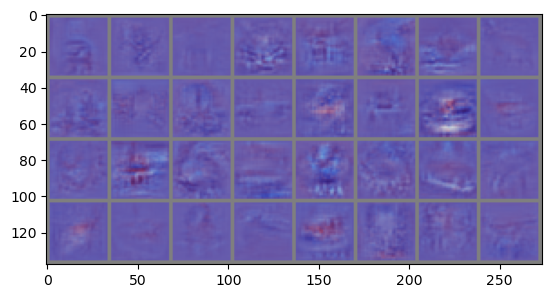

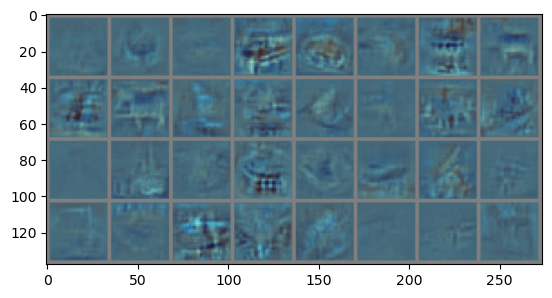

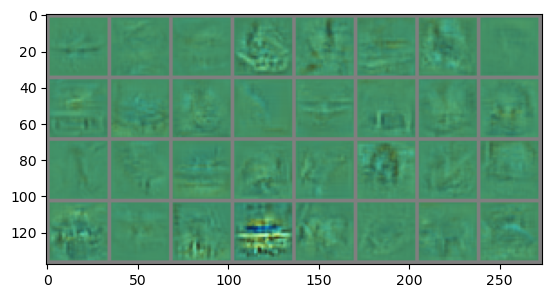

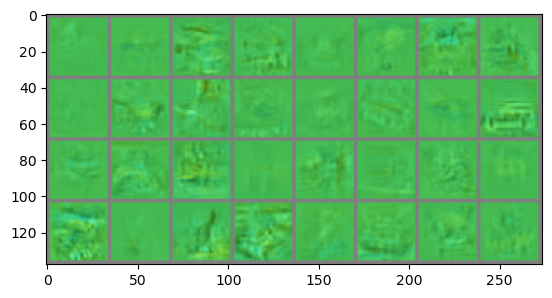

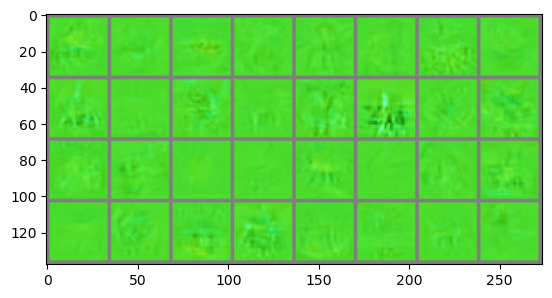

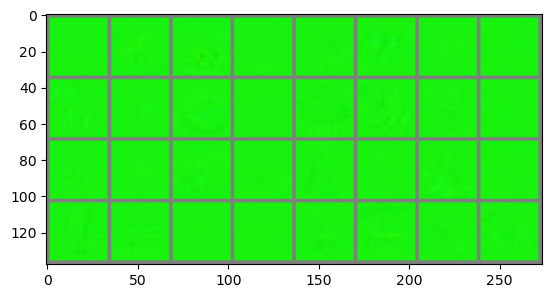

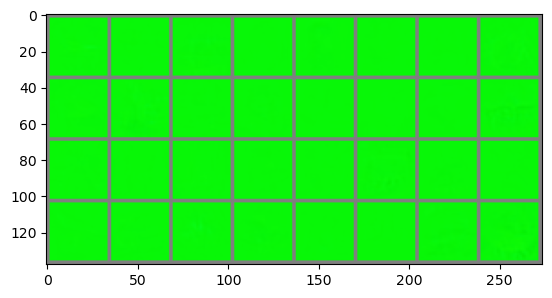

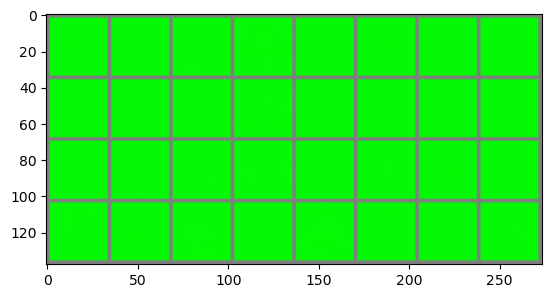

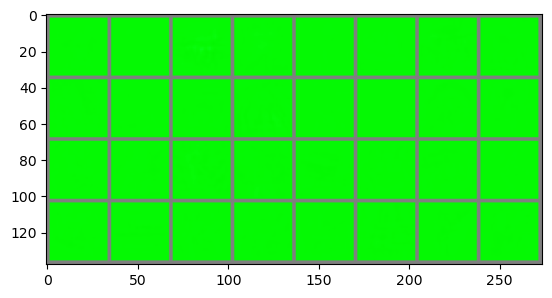

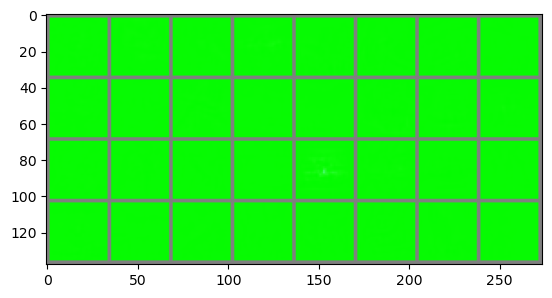

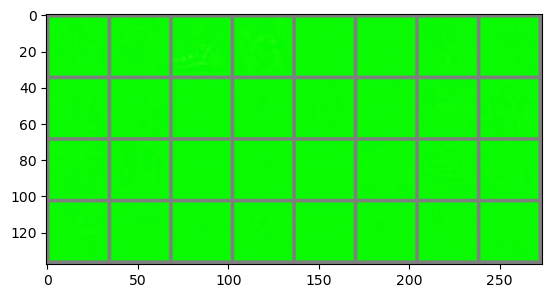

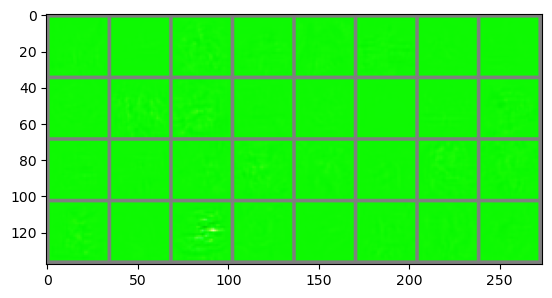

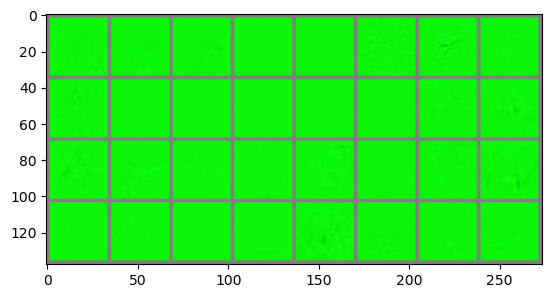

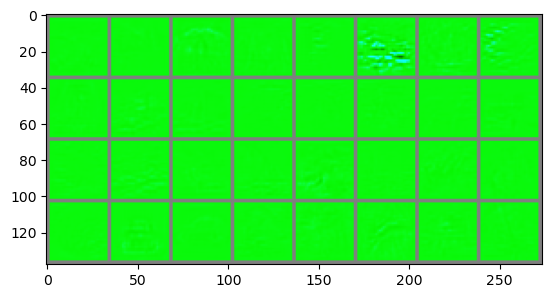

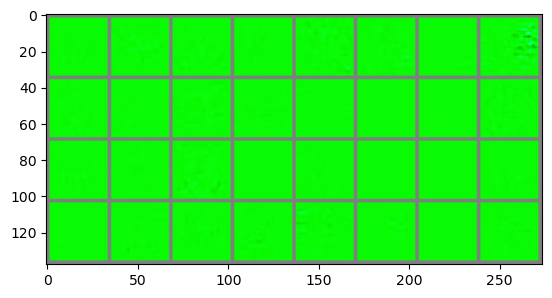

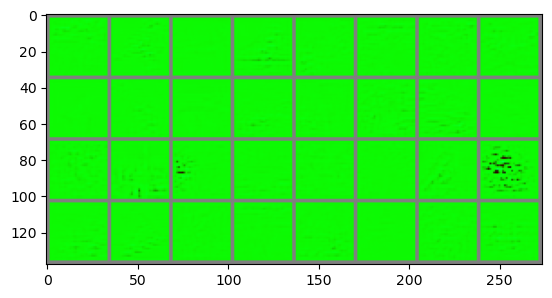

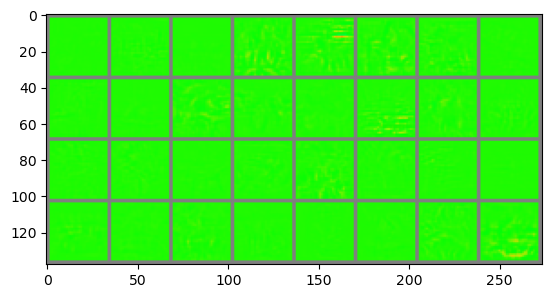

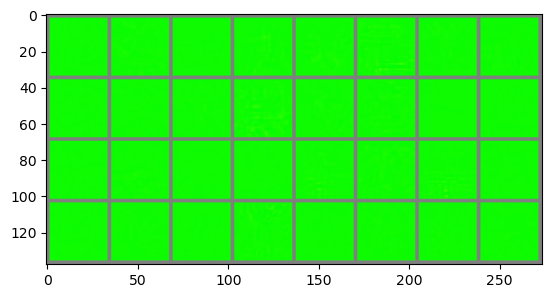

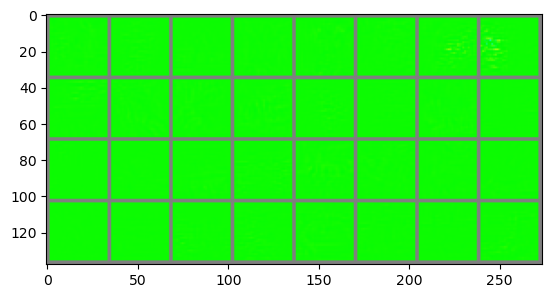

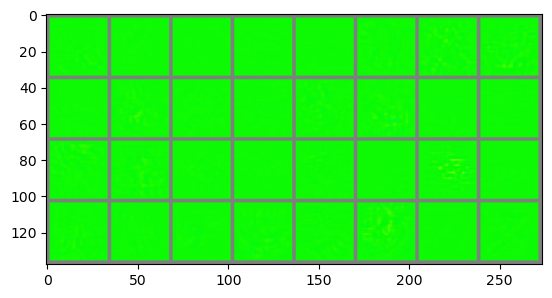

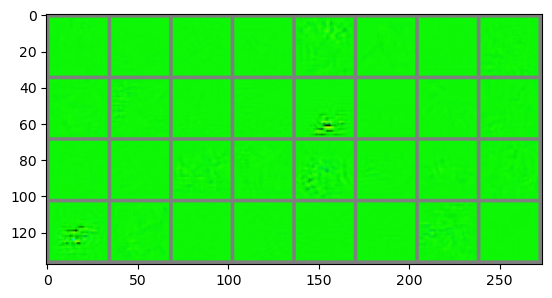

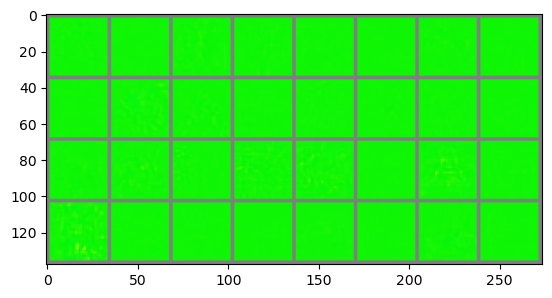

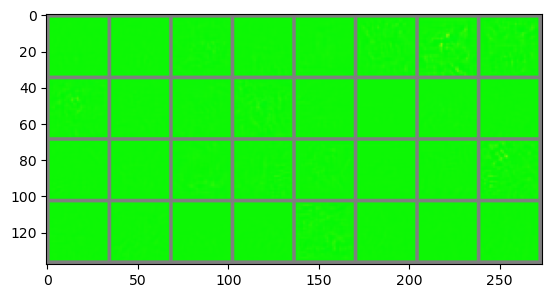

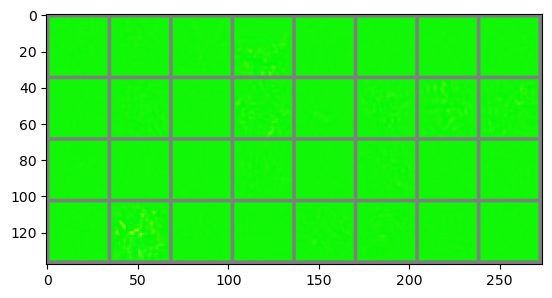

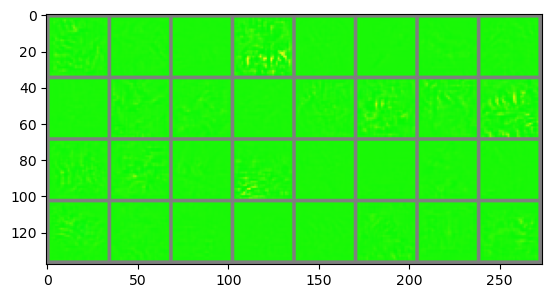

In [55]:
for j_prime in j_primes:
    imshow(torchvision.utils.make_grid(torch.from_numpy(j_prime)))
    plt.show()

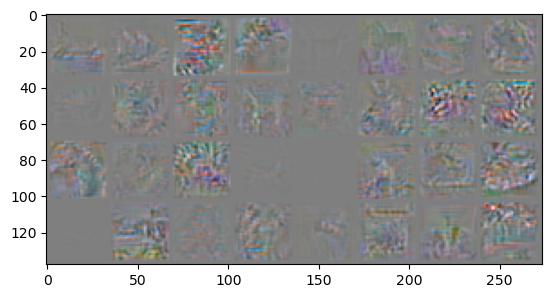

In [43]:
normalized_J = F.instance_norm(J)

imshow(torchvision.utils.make_grid(normalized_J.detach().cpu()))

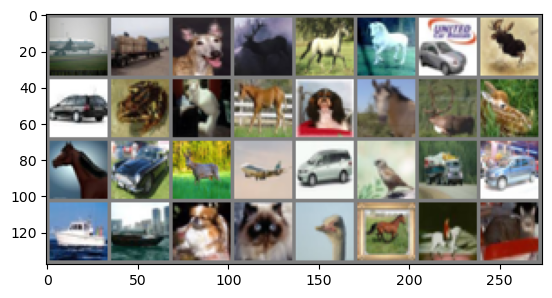

In [38]:
imshow(torchvision.utils.make_grid(data.detach().cpu()))